In [1]:
!nvidia-smi

Thu Feb  8 18:51:39 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:07:00.0 Off |                    0 |
| N/A   33C    P0    56W / 400W |   2138MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  Off  | 00000000:0B:00.0 Off |                    0 |
| N/A   

In [2]:
import os
import xarray as xr
from keras.models import load_model
import keras
import numpy as np
import matplotlib.pyplot as plt
import utils
plt.style.use('ggplot')

2024-02-08 18:51:42.926651: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-08 18:51:43.684672: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.4/lib64:/usr/local/cuda-11.4/lib64:/home/hpcs_rnd/anaconda3/envs/clone2/lib/
2024-02-08 18:51:43.684759: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.4/lib64:/usr/lo

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = str(utils.pick_gpu_lowest_memory())

In [4]:
os.chdir(os.getcwd())

## Load Data for which prediction has to be made

In [5]:
#select from q700, q850, spr, oro, sw1
EXT_VARIABLES=sorted(['q700','q850','spr','oro','sw1'])
LEADTIME=1


In [6]:
class datagen(keras.utils.Sequence):
  def __init__(self, dataset, batch_size, leadtime, in_frames, ext_variables = [],data_format = 'channels_first', \
                normalization='max_min',mean=None, std=None, max=None, min=None, mode='trainortest'):
    '''
    Assuming data format= channels first
    '''
    self.dataset = dataset
    self.batch_size = batch_size
    self.leadtime = leadtime
    self.in_frames = in_frames
    self.data_format = data_format
    self.normalization=normalization
    self.ext_variables=ext_variables
    self.mode=mode
  
    """
    assert(self.dataset.dims['time']-self.leadtime > 0) # only proceed if enough samples are there
    print(self.dataset.dims['time']-self.leadtime > 0)
    """
    if mode=='trainortest':
      self.samples = self.dataset.dims['time'] - (self.in_frames + self.leadtime-1) # effective number of samples
    elif mode=="forecast":
      self.samples = self.dataset.dims['time'] - (self.in_frames + self.leadtime-2)
      
    print("datasetdimstime.", self.dataset.dims["time"])
    print("self.inframes", self.in_frames)
    
    self.on_epoch_end()
    if self.normalization=='max_min':
        self.max = self.dataset.max(('time', 'lat', 'lon')).compute() if max is None else max
        self.min = self.dataset.min(('time', 'lat', 'lon')).compute() if min is None else min
        self.dataset=(self.dataset - self.min) / (self.max - self.min)
    
    """
    if self.normalization=='std':
      self.mean = self.dataset.mean(('time', 'lat', 'lon')).compute() if mean is None else mean #
      self.std = self.dataset.std('time').mean(('lat', 'lon')).compute() if std is None else std
      self.dataset = (self.dataset - self.mean) / self.std
    
    elif self.normalization=='max_min':
      self.max = self.dataset.max(('time', 'lat', 'lon')).compute() if max is None else max
      self.min = self.dataset.min(('time', 'lat', 'lon')).compute() if min is None else min
      self.dataset = 2 * ((self.dataset - self.min) / (self.max - self.min)) + 1
    """
    self.dataset.load()
  
  def on_epoch_end(self):
    'Store an np.ndarray of numbers of length of total number of samples'
    self.indexes = np.arange(self.samples)
    print("self+indexes=.", self.indexes)
  
  def __len__(self):
    'Return the number of batches per epoch that will be supplied depending on total number of samples'
    return int(np.floor(self.samples / self.batch_size))
  
  def __getitem__(self, index):
    'Generate (one) index-th batch of data'
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    print('indexes in getitem', indexes)
    print('index*self.batchsize', index*self.batch_size)
    print("self.batch_size",self.batch_size)
    
    X, y = self.core_generator(indexes)
    return X, y
  
  def core_generator(self, indexes):
    '''
    Output X, y of shape (batch_size, timestep, x, y
    '''
    X = []
    y = []
    q7=[]
    q85=[]
    spr=[]
    oro=[]
    sw1=[]
    


    # make supervised splits
    for i in range(len(indexes)):
      X.append(self.dataset['rain'].isel(time=slice(indexes[i], indexes[i] + self.in_frames)).values)
      if self.mode=="trainortest":
        y.append(self.dataset['rain'].isel(time=indexes[i] + (self.in_frames + self.leadtime - 1)).values)
      q7.append(self.dataset['q700'].isel(time=slice(indexes[i], indexes[i] + self.in_frames)).values)
      q85.append(self.dataset['q850'].isel(time=slice(indexes[i], indexes[i] + self.in_frames)).values)
      spr.append(self.dataset['sp'].isel(time=slice(indexes[i], indexes[i] + self.in_frames)).values)
      oro.append(self.dataset['z'].isel(time=slice(indexes[i], indexes[i] + self.in_frames)).values)
      sw1.append(self.dataset['swvl1'].isel(time=slice(indexes[i], indexes[i] + self.in_frames)).values)



        #No need to rollaxis for y since appending lat x lon 
    X=np.array(X)
    undefpts = np.where(X!=X)
    X[undefpts]=-1
    validpts = np.where(X>=0)
    X[validpts] = np.exp(X[validpts])#
    X[validpts] = np.power(X[validpts],7)
    X[undefpts] = 0#
    
    if self.mode=="trainortest":
      y=np.array(y)
      undefpts2=np.where(y!=y)
      y[undefpts2]=-1
      validpts2 = np.where(y>=0)
      y[validpts2] = np.exp(y[validpts2])#
      y[validpts2] = np.power(y[validpts2],7)
      y[undefpts2] = 0#
    q7=np.array(q7)
    q85=np.array(q85)
    spr=np.array(spr)
    oro=np.array(oro)
    sw1=np.array(sw1)
    
    if self.data_format == 'channels_first':
      im= X[:, :, np.newaxis, :, :]
      sph7=q7[:, :, np.newaxis, :, :]
      sph85=q85[:, :, np.newaxis, :, :]
      spr=spr[:, :, np.newaxis, :, :]
      o=oro[:, :, np.newaxis, :, :]
      sw1=sw1[:, :, np.newaxis, :, :]

      vars={'q700':sph7,'q850':sph85,'spr':spr, 'oro':o, 'sw1':sw1}
      if len(self.ext_variables)==0:
        data=im
      elif len(self.ext_variables)==5:
        data=np.concatenate([im, sph7, sph85, spr, o, sw1], axis=2)
      else:
        for ind, var in enumerate(self.ext_variables):
          if ind==0:
            data=np.concatenate([im, vars[var]], axis=2)
          else:
            data=np.concatenate([data,vars[var]], axis=2)
            
      if self.mode=="trainortest":
        X, y = data, y[:, np.newaxis, :, :]
      else:
        X, y = data, y
    """
    elif self.data_format == 'channels_last':
      X, y = X[:, :, :, :, np.newaxis], y[:, :, :, np.newaxis]
    """
    return X, y


In [7]:
imd_z=xr.open_dataset("./data/rf_allvar_1979-2019.nc")
print(imd_z)

<xarray.Dataset>
Dimensions:  (time: 14975, lat: 129, lon: 135)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-12-31
  * lat      (lat) float64 6.5 6.75 7.0 7.25 7.5 ... 37.5 37.75 38.0 38.25 38.5
  * lon      (lon) float64 66.5 66.75 67.0 67.25 67.5 ... 99.25 99.5 99.75 100.0
Data variables:
    rain     (time, lat, lon) float64 ...
    q700     (time, lat, lon) float32 ...
    q850     (time, lat, lon) float32 ...
    sp       (time, lat, lon) float32 ...
    z        (time, lat, lon) float32 ...
    swvl1    (time, lat, lon) float32 ...
Attributes:
    Units:    rain(mm), q700(kg kg-1), q850(kg kg-1), sp(Pa), z(m2 s-2), swvl...


In [8]:
input=imd_z.sel(time=slice('2011-08-02','2011-08-06')).rain.values

In [9]:
low = 0
high = 55
step = 5
zstr=[]
for i in range(low, high+step, step):
  zstr.append(str(i))
print(zstr)
zint=[]
for i in range(low, high+step, step):
  zint.append((i))
print(zint)
lon_low = 14
lon_high = 135
lon_step = 20
lon_zstr=[]
for i in range(lon_low, lon_high, lon_step):
  lon_zstr.append(str(66.5+i*.25))
print(lon_zstr)
lon_zint=[]
for i in range(lon_low, lon_high, lon_step):
  lon_zint.append((i))
print(lon_zint)
lat_low = 14
lat_high = 120
lat_step = 20
lat_zstr=[]
for i in range(lat_low, lat_high, lat_step):
  lat_zstr.append(str(6.5+i*.25))
print(lat_zstr)
lat_zint=[]
for i in range(lat_low, lat_high, lat_step):
  lat_zint.append((i))
print(lat_zint)

['0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55']
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
['70.0', '75.0', '80.0', '85.0', '90.0', '95.0', '100.0']
[14, 34, 54, 74, 94, 114, 134]
['10.0', '15.0', '20.0', '25.0', '30.0', '35.0']
[14, 34, 54, 74, 94, 114]


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


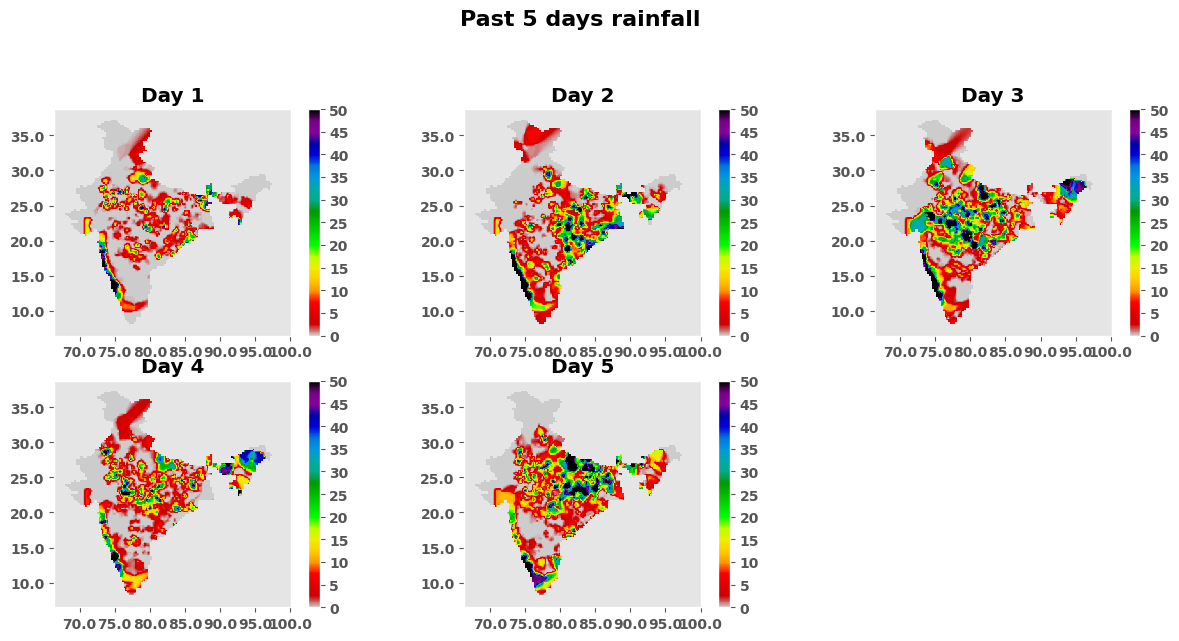

In [10]:
fig = plt.figure(figsize=(15,10))
fig.suptitle('Past 5 days rainfall', fontsize=16, weight='bold')
ax1=fig.add_subplot(331)
plt.imshow(input[0,:,:],cmap='nipy_spectral_r',vmin=0,vmax=50)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Times New Roman'
ax1.set_ylim(0,129)
ax1.set_xticks(lon_zint)
ax1.set_xticklabels(lon_zstr, weight='bold', fontsize=10)
ax1.set_yticks(lat_zint)
ax1.set_yticklabels(lat_zstr, weight='bold', fontsize=10)
plt.colorbar(ticks=zint).ax.set_yticklabels(zstr,weight='bold', fontsize=10)
plt.title("Day 1", weight='bold')
plt.grid()



ax2=fig.add_subplot(332)
plt.imshow(input[1,:,:],cmap='nipy_spectral_r',vmin=0,vmax=50)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Times New Roman'
ax2.set_ylim(0,129)
ax2.set_xticks(lon_zint)
ax2.set_xticklabels(lon_zstr, weight='bold', fontsize=10)
ax2.set_yticks(lat_zint)
ax2.set_yticklabels(lat_zstr, weight='bold', fontsize=10)
plt.title("Day 2", weight='bold')
plt.colorbar(ticks=zint).ax.set_yticklabels( zstr,weight='bold', fontsize=10)
plt.grid()

ax3=fig.add_subplot(333)
plt.imshow(input[2,:,:],cmap='nipy_spectral_r',vmin=0,vmax=50)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Times New Roman'
ax3.set_ylim(0,129)
ax3.set_xticks(lon_zint)
ax3.set_xticklabels(lon_zstr, weight='bold', fontsize=10)
ax3.set_yticks(lat_zint)
ax3.set_yticklabels(lat_zstr, weight='bold', fontsize=10)
plt.title("Day 3", weight='bold')
plt.colorbar(ticks=zint).ax.set_yticklabels( zstr,weight='bold', fontsize=10)
plt.grid()

ax4=fig.add_subplot(334)
plt.imshow(input[3,:,:],cmap='nipy_spectral_r',vmin=0,vmax=50)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Times New Roman'
ax4.set_ylim(0,129)
ax4.set_xticks(lon_zint)
ax4.set_xticklabels(lon_zstr, weight='bold', fontsize=10)
ax4.set_yticks(lat_zint)
ax4.set_yticklabels(lat_zstr, weight='bold', fontsize=10)
plt.title("Day 4", weight='bold')
plt.colorbar(ticks=zint).ax.set_yticklabels( zstr,weight='bold', fontsize=10)
plt.grid()

ax5=fig.add_subplot(335)
plt.imshow(input[4,:,:],cmap='nipy_spectral_r',vmin=0,vmax=50)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Times New Roman'
ax5.set_ylim(0,129)
ax5.set_xticks(lon_zint)
ax5.set_xticklabels(lon_zstr, weight='bold', fontsize=10)
ax5.set_yticks(lat_zint)
ax5.set_yticklabels(lat_zstr, weight='bold', fontsize=10)
plt.title("Day 5", weight='bold')
plt.colorbar(ticks=zint).ax.set_yticklabels( zstr,weight='bold', fontsize=10)
plt.grid()


## Load Model

In [11]:
# load model
try:
    var_string='_'.join(EXT_VARIABLES)
except:
    var_string=''
    
seq_path = "./models"

print(os.path.join(seq_path, f'ld{LEADTIME}_{len(EXT_VARIABLES)}extvars_{var_string}.h5'))

try:
    seq = load_model(os.path.join(seq_path, f'ld{LEADTIME}_{len(EXT_VARIABLES)}extvars_{var_string}.h5'))
    print('Model file found')
except Exception as e:
    print(e)

print(seq.summary())

./models/ld1_5extvars_oro_q700_q850_spr_sw1.h5


2024-02-08 18:51:47.567272: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-08 18:51:48.277652: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38402 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:0b:00.0, compute capability: 8.0


Model file found
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lst_m2d (ConvLSTM2D)   (None, None, 4, 129, 135  1456      
                             )                                   
                                                                 
 conv_lst_m2d_1 (ConvLSTM2D)  (None, None, 8, 129, 135  3488     
                             )                                   
                                                                 
 conv_lst_m2d_2 (ConvLSTM2D)  (None, None, 8, 129, 135  4640     
                             )                                   
                                                                 
 conv_lst_m2d_3 (ConvLSTM2D)  (None, None, 16, 129, 13  13888    
                             5)                                  
                                                                 
 conv_lst_m2d_4 (ConvLSTM2D)  (None, 16

In [12]:
os.listdir('./models')

['ld1_2extvars_oro_q700.h5',
 'ld1_5extvars_oro_q700_q850_spr_sw1.h5',
 'ld1_0extvars_.h5']

In [13]:
EXT_VARIABLES

['oro', 'q700', 'q850', 'spr', 'sw1']

In [14]:
print(seq.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lst_m2d (ConvLSTM2D)   (None, None, 4, 129, 135  1456      
                             )                                   
                                                                 
 conv_lst_m2d_1 (ConvLSTM2D)  (None, None, 8, 129, 135  3488     
                             )                                   
                                                                 
 conv_lst_m2d_2 (ConvLSTM2D)  (None, None, 8, 129, 135  4640     
                             )                                   
                                                                 
 conv_lst_m2d_3 (ConvLSTM2D)  (None, None, 16, 129, 13  13888    
                             5)                                  
                                                                 
 conv_lst_m2d_4 (ConvLSTM2D)  (None, 16, 129, 135)     1

## Model Prediction

In [15]:
T=imd_z.sel(time=slice('2000','2015')).max(('time', 'lat', 'lon')).compute()
dat=imd_z.sel(time=slice('2011-12-05','2011-12-09'))
dg_test=datagen(dat, batch_size=1, leadtime=LEADTIME, in_frames=5, max=T, ext_variables=EXT_VARIABLES, mode="forecast") #to be used as input for prediction

datasetdimstime. 5
self.inframes 5
self+indexes=. [0]


In [16]:
yhat=seq.predict(dg_test)

indexes in getitem [0]
index*self.batchsize 0
self.batch_size 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
indexes in getitem [0]
index*self.batchsize 0
self.batch_size 1


2024-02-08 18:51:53.710748: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204


1/1 [==============================] - 4s 4s/step


## Convert back to Normal spacce

In [17]:
try:
    T=T.rain.values
except:
    pass

In [18]:
T

array(822.06329346)

In [19]:
input[0].shape

(129, 135)

In [20]:
y=np.array(input[0])
undefpts2=np.where(y!=y)
y[undefpts2]=-1
validpts2 = np.where(y>=0)
y[validpts2] = np.exp(y[validpts2])#
y[validpts2] = np.power(y[validpts2],7)
y[undefpts2] = 0#

/home/hpcs_rnd/anaconda3/envs/clone2/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in power
  


In [21]:
# Convert back into normal space
vals=y.reshape(1,1,129,135)
a = np.where(vals>=1)
b = np.where(vals==0)

yhat[:,:,:,:][a] = np.power(yhat[:,:,:,:][a],1/7)
yhat[:,:,:,:][a] = np.log(yhat[:,:,:,:][a])
yhat[:,:,:,:][a] = yhat[:,:,:,:][a]*(T)
c = np.where(yhat[:,:,:,:]<=0)
yhat[:,:,:,:][c] = 0
yhat[:,:,:,:][b] = np.nan

## Plot Prediction

/home/hpcs_rnd/anaconda3/envs/clone2/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


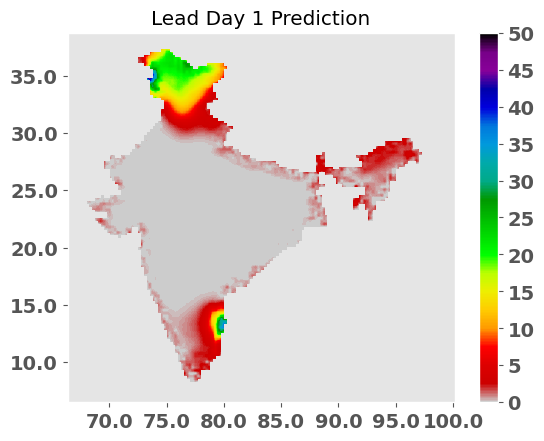

In [22]:
plt.imshow(yhat[0,0,:,:],cmap='nipy_spectral_r',vmin=0,vmax=50)  # set vmin and vmax as arguments in imshow to adjust for scale
ax1 = plt.axes()
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Times New Roman'
ax1.set_ylim(0,129)
ax1.set_xticks(lon_zint)
ax1.set_xticklabels(lon_zstr, weight='bold', fontsize=14)
ax1.set_yticks(lat_zint)
ax1.set_yticklabels(lat_zstr, weight='bold', fontsize=14)
plt.title('Lead Day 1 Prediction')
plt.colorbar(ticks=zint).ax.set_yticklabels( zstr,weight='bold', fontsize=14)
plt.grid()
# plt.savefig(seq_path+'GroundTruth_ld%d.png'% leadtime,dpi=400,format='png',figsize=(5, 9))
# plt.show()
# plt.clf()

#### Iterate

In [23]:
dat

<xarray.Dataset>
Dimensions:  (time: 5, lat: 129, lon: 135)
Coordinates:
  * time     (time) datetime64[ns] 2011-12-05 2011-12-06 ... 2011-12-09
  * lat      (lat) float64 6.5 6.75 7.0 7.25 7.5 ... 37.5 37.75 38.0 38.25 38.5
  * lon      (lon) float64 66.5 66.75 67.0 67.25 67.5 ... 99.25 99.5 99.75 100.0
Data variables:
    rain     (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    q700     (time, lat, lon) float32 0.008149 0.008086 ... 0.000768 0.0009597
    q850     (time, lat, lon) float32 0.01309 0.013 ... 0.000768 0.0008829
    sp       (time, lat, lon) float32 1.009e+05 1.009e+05 ... 6.953e+04
    z        (time, lat, lon) float32 -0.3965 -1.277 ... 3.529e+04 3.122e+04
    swvl1    (time, lat, lon) float32 -8.407e-07 -8.407e-07 ... 0.3516 0.3494
Attributes:
    Units:    rain(mm), q700(kg kg-1), q850(kg kg-1), sp(Pa), z(m2 s-2), swvl...

In [24]:
dat['time'].values[1:]

array(['2011-12-06T00:00:00.000000000', '2011-12-07T00:00:00.000000000',
       '2011-12-08T00:00:00.000000000', '2011-12-09T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [25]:
new_dat=np.vstack((dat['rain'].values[1:],yhat[0]))

In [26]:
new_dat[4]

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [27]:
# Calculate the next day
next_day = dat['time'].values[1:][-1] + np.timedelta64(1, 'D')

# Add the next day as the 5th element
extended_dates = np.append(dat['time'].values[1:], next_day)

In [28]:
extended_dates

array(['2011-12-06T00:00:00.000000000', '2011-12-07T00:00:00.000000000',
       '2011-12-08T00:00:00.000000000', '2011-12-09T00:00:00.000000000',
       '2011-12-10T00:00:00.000000000'], dtype='datetime64[ns]')

In [29]:
dat["sp"].values[1:]

array([[[100939.59 , 100940.75 , 100939.49 , ..., 100744.76 ,
         100800.99 , 100672.57 ],
        [100934.84 , 100940.68 , 100939.27 , ..., 101029.65 ,
         100892.695,  99771.664],
        [100939.22 , 100945.695, 100940.12 , ..., 101179.555,
         100060.375,  98921.25 ],
        ...,
        [ 88420.09 ,  86710.2  ,  90010.19 , ...,  62099.38 ,
          62717.45 ,  63685.11 ],
        [ 89783.5  ,  85293.305,  84422.984, ...,  62911.26 ,
          63735.934,  64618.41 ],
        [ 91786.91 ,  86752.75 ,  80215.24 , ...,  63776.785,
          65272.418,  68998.305]],

       [[100947.57 , 100947.22 , 100946.02 , ..., 100648.56 ,
         100699.87 , 100567.73 ],
        [100942.44 , 100948.78 , 100947.57 , ..., 100936.71 ,
         100794.56 ,  99674.68 ],
        [100946.85 , 100953.88 , 100948.76 , ..., 101087.18 ,
          99966.03 ,  98828.664],
        ...,
        [ 88355.27 ,  86687.24 ,  90019.38 , ...,  62404.594,
          63037.78 ,  64029.215],
        [ 89

In [30]:
dat["sp"].values[-1].shape

(129, 135)

In [31]:
np.vstack((dat["sp"].values[1:], dat["sp"].values[-1][np.newaxis, :, :]))

array([[[100939.59 , 100940.75 , 100939.49 , ..., 100744.76 ,
         100800.99 , 100672.57 ],
        [100934.84 , 100940.68 , 100939.27 , ..., 101029.65 ,
         100892.695,  99771.664],
        [100939.22 , 100945.695, 100940.12 , ..., 101179.555,
         100060.375,  98921.25 ],
        ...,
        [ 88420.09 ,  86710.2  ,  90010.19 , ...,  62099.38 ,
          62717.45 ,  63685.11 ],
        [ 89783.5  ,  85293.305,  84422.984, ...,  62911.26 ,
          63735.934,  64618.41 ],
        [ 91786.91 ,  86752.75 ,  80215.24 , ...,  63776.785,
          65272.418,  68998.305]],

       [[100947.57 , 100947.22 , 100946.02 , ..., 100648.56 ,
         100699.87 , 100567.73 ],
        [100942.44 , 100948.78 , 100947.57 , ..., 100936.71 ,
         100794.56 ,  99674.68 ],
        [100946.85 , 100953.88 , 100948.76 , ..., 101087.18 ,
          99966.03 ,  98828.664],
        ...,
        [ 88355.27 ,  86687.24 ,  90019.38 , ...,  62404.594,
          63037.78 ,  64029.215],
        [ 89

In [32]:
ds= xr.Dataset({
    "rain":(["time", "lat", "lon"], new_dat),
    "q700":(["time", "lat", "lon"], np.vstack((dat["q700"].values[1:], dat["q700"].values[-1][np.newaxis, :, :]))),
    "q850":(["time", "lat", "lon"], np.vstack((dat["q850"].values[1:], dat["q850"].values[-1][np.newaxis, :, :]))),
    "sp":(["time", "lat", "lon"], np.vstack((dat["sp"].values[1:], dat["sp"].values[-1][np.newaxis, :, :]))),
    "z":(["time", "lat", "lon"], dat["z"].values),
    "swvl1":(["time", "lat", "lon"], np.vstack((dat["swvl1"].values[1:], dat["swvl1"].values[-1][np.newaxis, :, :])))
    
    
},
    coords={
        "time":extended_dates,
        "lat":np.arange(6.5,38.75, 0.25),
        "lon":np.arange(66.5,100.25, 0.25)
    }
)

In [33]:
ds

<xarray.Dataset>
Dimensions:  (time: 5, lat: 129, lon: 135)
Coordinates:
  * time     (time) datetime64[ns] 2011-12-06 2011-12-07 ... 2011-12-10
  * lat      (lat) float64 6.5 6.75 7.0 7.25 7.5 ... 37.5 37.75 38.0 38.25 38.5
  * lon      (lon) float64 66.5 66.75 67.0 67.25 67.5 ... 99.25 99.5 99.75 100.0
Data variables:
    rain     (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    q700     (time, lat, lon) float32 0.008069 0.008084 ... 0.000768 0.0009597
    q850     (time, lat, lon) float32 0.01257 0.01253 ... 0.000768 0.0008829
    sp       (time, lat, lon) float32 1.009e+05 1.009e+05 ... 6.953e+04
    z        (time, lat, lon) float32 -0.3965 -1.277 ... 3.529e+04 3.122e+04
    swvl1    (time, lat, lon) float32 6.867e-07 6.867e-07 ... 0.3516 0.3494

In [34]:
dg_test=datagen(ds, batch_size=1, leadtime=LEADTIME, in_frames=5, max=T, ext_variables=EXT_VARIABLES, mode="forecast") 

datasetdimstime. 5
self.inframes 5
self+indexes=. [0]


In [35]:
yhat=seq.predict(dg_test)

indexes in getitem [0]
index*self.batchsize 0
self.batch_size 1
indexes in getitem [0]
index*self.batchsize 0
self.batch_size 1
1/1 [==============================] - 0s 72ms/step
